In [4]:
a = {"dfs":1,"dfs1":2}
print(a.items())

dict_items([('dfs', 1), ('dfs1', 2)])


In [5]:
type(a)

dict

In [ ]:
import os
import cv2
from qibullet import Camera
from qibullet.camera import CameraRgb
from qibullet.camera import CameraDepth
import gym
import time

from datetime import datetime
import numpy as np
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO as PPO2
from stable_baselines3 import DDPG

import pybullet as p
import pybullet_data
from qibullet import PepperVirtual
from qibullet import SimulationManager
from urllib.request import Request, urlopen



class PepperEnv(gym.Env):    
    def __init__(self,gui = True):

        # the kinematic chain which will be used to create the policy
        self.Left_kinematic_chain = [
            "LShoulderPitch",
            "LShoulderRoll",
            "LElbowRoll",
            "LElbowYaw",
            "LWristYaw"]
        
        # list of values defining the robot initial state
        self.initial_stand = [
            1.580,
            0.117,
            -0.518,
            -1.218,
            -0.031]
        self.joints_initial_pose = list()

        # variables defining the rl episodes
        self.episode_start_time = None
        self.episode_over = False
        self.episode_failed = False
        self.episode_reward = 0.0
        self.episode_number = 0
        self.episode_steps = 0

        self.simulation_manager = SimulationManager()

        self.gui = gui
        self._setupScene()
        lower_limits = list()
        upper_limits = list()
        # kinematics ranges
        lower_limits.extend([self.pepper.joint_dict[joint].getLowerLimit() for
                            joint in self.Left_kinematic_chain])
        upper_limits.extend([self.pepper.joint_dict[joint].getUpperLimit() for
                            joint in self.Left_kinematic_chain])
        # Add gripper position and rotation to the limits
        lower_limits.extend([-2, -2, 0, -1, -1, -1, -1])
        upper_limits.extend([2, 2, 3, 1, 1, 1, 1])
        self.observation_space = gym.spaces.Dict({
            "kinematics":gym.spaces.Box(low = np.array(lower_limits),
                                        high = np.array(upper_limits),shape=(12,)),
                                        
                                        
            "image":gym.spaces.Box(low=0, high=255, shape=(320, 240, 3)) 
            })
        velocity_limits = [
            self.pepper.joint_dict[joint].getMaxVelocity() for
            joint in self.Left_kinematic_chain]
        velocity_limits.extend([
            -self.pepper.joint_dict[joint].getMaxVelocity() for
            joint in self.Left_kinematic_chain])

        normalized_limits = self.normalize(velocity_limits)
        self.max_velocities = normalized_limits[:len(self.Left_kinematic_chain)]
        self.min_velocities = normalized_limits[len(self.Left_kinematic_chain):]
        self.action_space = gym.spaces.Box(
            low=np.array(self.min_velocities),
            high=np.array(self.max_velocities))
        self.robot_body_id = self.pepper.robot_model
        
                
                
    def normalize(self, values, range_min=-1.0, range_max=1.0):
        """
        Normalizes values (list) according to a specific range
        """
        zero_bound = [x - min(values) for x in values]
        range_bound = [
            x * (range_max - range_min) / (max(zero_bound) - min(zero_bound))
            for x in zero_bound]
        
        return [x - max(range_bound) + range_max for x in range_bound]

    def _setupScene(self):
        """
        Setup a scene environment within the simulation
        """
        self.client = self.simulation_manager.launchSimulation(gui=self.gui)
        self.pepper = self.simulation_manager.spawnPepper(
            self.client,
            spawn_ground_plane=True)

        self.pepper.goToPosture("Stand", 1.0)
        self.pepper.setAngles(  
            self.Left_kinematic_chain,
            self.initial_stand,
            1.0)

        time.sleep(1.0)
        self.joints_initial_pose = self.pepper.getAnglesPosition(
            self.pepper.joint_dict.keys())
        table_visual_shape_id = p.createVisualShape(
            shapeType=p.GEOM_BOX,
            halfExtents=[0.4, 0.4, 0.02],
            rgbaColor=[0.9, 0.9, 0.9, 1.0])
        table_collision_shape_id = p.createCollisionShape(
            shapeType=p.GEOM_BOX,
            halfExtents=[0.4, 0.4, 0.02])
        table_position = [0.6, 0.0, .8  ]  # Modify this position to place the table where you want
        self.table_body_id = p.createMultiBody(
            baseMass=0.0,
            baseInertialFramePosition=[0.0, 0.0, 0.0],
            baseCollisionShapeIndex=table_collision_shape_id,
            baseVisualShapeIndex=table_visual_shape_id,
            basePosition=table_position)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        self.soda = p.loadURDF(
            r"D:\projects\graduation project\qi bullet simulation\soda_can.urdf",
            basePosition=[0.345, 0.1, .9],
            globalScaling=1,
            physicsClientId=self.client)
        time.sleep(0.2)

    def step(self, action):
        try:
            action = list(action)
            assert len(action) == len(self.action_space.high.tolist())

        except AssertionError:
            print("Incorrect action")
            return None, None, None, None

        self.episode_steps += 1
        np.clip(action, self.min_velocities, self.max_velocities)
        self._setVelocities(self.Left_kinematic_chain, action)

        obs, reward = self._getState()
        return obs, reward, self.episode_over, {}


    
        
        
    def _getState(self, convergence_norm=0.15):

        reward = 0.0
        if self.pepper.isSelfColliding("l_wrist") or\
                self.pepper.isSelfColliding("LForeArm"):
            self.episode_over = True
            self.episode_failed = True
            reward += -1
        elif (time.time() - self.episode_start_time) > 5:
            self.episode_over = True
            self.episode_failed = True
            reward += -1
        for link_id in [48,49]:
                    contact_points = p.getContactPoints(self.robot_body_id, self.soda, linkIndexA=link_id)
                    if len(contact_points) > 0:
                        print("Collision detected between the can and link", link_id)
                        self.episode_over = True
                        self.episode_failed = False
                        reward+=1

        for link_id in range(p.getNumJoints(self.robot_body_id)):
                    contact_points = p.getContactPoints(self.robot_body_id, self.table_body_id, linkIndexA=link_id)
                    if len(contact_points) > 0:
                        print("Collision detected between the table and link", link_id)
                        
                        reward += -3

        obs = self._getObservation()

        self.episode_reward += reward

        if self.episode_over:
            self.episode_number += 1
            self._printEpisodeSummary()

        return obs, reward
    



    def _hardResetJointState(self):
        for joint, position in\
                zip(self.pepper.joint_dict.keys(), self.joints_initial_pose):
            p.setJointMotorControl2(
                self.pepper.robot_model,
                self.pepper.joint_dict[joint].getIndex(),
                p.VELOCITY_CONTROL,
                targetVelocity=0.0)
            p.resetJointState(
                    self.pepper.robot_model,
                    self.pepper.joint_dict[joint].getIndex(),
                    position)

    def _resetScene(self):
        p.resetBasePositionAndOrientation(
                self.robot_model,
            posObj=[0.0, 0.0, 0.0],
            ornObj=[0.0, 0.0, 0.0, 1.0],
            physicsClientId=self.client)
        self._hardResetJointState()
        p.resetBasePositionAndOrientation(
            self.soda,
            posObj=self.initial_projectile_pose,    
            ornObj=[0.0, 0.0, 0.0, 1.0],
            physicsClientId=self.client)
        p.resetBasePositionAndOrientation(
            self.table_body_id,
            posObj=self._computeBucketSpawnPose(),
            ornObj=[0.0, 0.0, 0.0, 1.0],
            physicsClientId=self.client)

        time.sleep(0.2)

        

    def _printEpisodeSummary(self, info_dict={}):
      
        if self.episode_failed:
            episode_status = "FAILURE"
        else:
            episode_status = "SUCCESS"

        print("#---------Episode-Summary---------#")
        print("Episode number: " + str(self.episode_number))
        print("Episode's number of steps: " + str(self.episode_steps))
        print("Episode status: " + episode_status)
        print("Episode reward: " + str(self.episode_reward))

        for key, value in info_dict.items():
            print(key + ": " + str(value))

    def _termination(self):
        self.simulation_manager.stopSimulation(self.client)


    def _getLinkPosition(self, link_name):
        link_state = p.getLinkState(
            self.pepper.robot_model,
            self.pepper.link_dict[link_name].getIndex())


    def _getObservation(self):
    
        gripper_pose, gripper_rot = self._getLinkPosition("l_gripper")
        

        image = self.camera_view(self.pepper)
        # # Fill and return the observation
        
        kinematics = self.pepper.getAnglesPosition(self.Left_kinematic_chain) +\
        [pose for pose in gripper_pose] +\
        [rot for rot in gripper_rot]


        obs = {"kinematics":kinematics,"image":image}
        return obs



    def _setVelocities(self, angles, normalized_velocities):

        for angle, velocity in zip(angles, normalized_velocities):
            # Unnormalize the velocity
            velocity *= self.pepper.joint_dict[angle].getMaxVelocity()

            position = self.pepper.getAnglesPosition(angle)
            lower_limit = self.pepper.joint_dict[angle].getLowerLimit()
            upper_limit = self.pepper.joint_dict[angle].getUpperLimit()

            if position <= lower_limit and velocity < 0.0:
                velocity = 0.0
                self.episode_failed = True
            elif position >= upper_limit and velocity > 0.0:
                velocity = 0.0
                self.episode_failed = True

            p.setJointMotorControl2(
                self.pepper.robot_model,
                self.pepper.joint_dict[angle].getIndex(),
                p.VELOCITY_CONTROL,
                targetVelocity=velocity,
                force=self.pepper.joint_dict[angle].getMaxEffort())

    def camera_view(self,perspective):
            handle_bottom = perspective.subscribeCamera(
            PepperVirtual.ID_CAMERA_BOTTOM,
            resolution=Camera.K_QVGA,
            fps=20)
            img_bottom = perspective.getCameraFrame(handle_bottom)
      
            return img_bottom

if __name__ == "__main__":


    env = PepperEnv(gui=1)
    vec_env = DummyVecEnv([lambda: env])

    model = PPO2(
                MultiInputPolicy,
                env,
                # nminibatches=1,
                verbose=0,
                # buffer_size=100,
                tensorboard_log="exp1")

    model.learn(total_timesteps=100)


    










In [ ]:
from typing import Callable, Dict, List, Optional, Tuple, Type, Union

from gym import spaces
import torch as th
from torch import nn

from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy


class CustomNetwork(nn.Module):
    """
    Custom network for policy and value function.
    It receives as input the features extracted by the features extractor.

    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 64,
        last_layer_dim_vf: int = 64,
    ):
        super().__init__()

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        # Policy network
        self.policy_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_pi), nn.ReLU()
        )
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_vf), nn.ReLU()
        )

    def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        return self.forward_actor(features), self.forward_critic(features)

    def forward_actor(self, features: th.Tensor) -> th.Tensor:
        return self.policy_net(features)

    def forward_critic(self, features: th.Tensor) -> th.Tensor:
        return self.value_net(features)


class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule: Callable[[float], float],
        *args,
        **kwargs,
    ):

        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
        # Disable orthogonal initialization
        self.ortho_init = False

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)


model = PPO(CustomActorCriticPolicy, "CartPole-v1", verbose=1)
model.learn(5000)




# custom network code for further research 

In [1]:
from stable_baselines3.common.env_checker import check_env
from main import PepperEnv
env = PepperEnv()
check_env(env)

c:\Users\user\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


AssertionError: Your environment must inherit from the gym.Env class cf https://github.com/openai/gym/blob/master/gym/core.py

In [2]:
import qibullet
qibullet.__version__

'1.4.6'

In [4]:
import qibullet

# create a Qibullet simulation instance
simulation = qibullet.SimulationManager().launchSimulation()

# spawn a Pepper robot in the simulation
pepper = simulation.spawnPepper()

# get the link of the head of the robot
head_link = pepper.getLinkFromName("Head")

# create a depth camera for the robot's head
depth_camera = qibullet.camera.CameraDepth(
    pepper,
    0,  # camera ID
    head_link,
    hfov=69.4,
    vfov=42.5,
    resolution=qibullet.camera.Camera.K_QVGA
)

# start the depth camera's frame extraction loop
depth_camera.start()


AttributeError: 'int' object has no attribute 'spawnPepper'

In [ ]:
from stable_baselines3 import A2C


In [2]:
import pybullet as p

# Load the robot and get its ID
robot_id = p.loadURDF("path/to/robot.urdf")

# Get the collision shape information for the robot
num_collision_shapes = p.getNumJoints(robot_id)
collision_shapes = []
for i in range(num_collision_shapes):
    collision_shape_info = p.getCollisionShapeData(robot_id, i)
    collision_shapes.append(collision_shape_info)
    
# Print the collision shape information
print(collision_shapes)

error: Not connected to physics server.

In [3]:
from pyb_utils import scripts

ImportError: cannot import name 'scripts' from 'pyb_utils' (c:\Users\user\anaconda3\lib\site-packages\pyb_utils\__init__.py)

In [4]:
import cv2 
import numpy as np 
depth_image = r"D:\projects\graduation project\qi bullet simulation\qi sdk\pepper_image.jpg"
depth_image = np.array(cv2.imread(depth_image,cv2.IMREAD_GRAYSCALE))

# depth_image_normalized = cv2.normalize(depth_image, None, 0, 255, cv2.NORM_MINMAX)
# print(depth_image_normalized)
# Invert the depth values (so closer objects are lighter)
depth_image_inverted = 255 - depth_image

# Apply a square root mapping to the depth values
depth_image_sqrt = np.sqrt(depth_image_inverted)
depth_image_sqrt = np.array(depth_image_sqrt,dtype=np.float32)
# Normalize the mapped depth image to 0-255 range
depth_image_normalized = cv2.normalize(depth_image_sqrt, None, 0, 255, cv2.NORM_MINMAX)

# Convert the depth image to 8-bit unsigned integer format
depth_image_uint8 = depth_image_normalized.astype(np.uint8)

# Apply a color map to the depth image
depth_colormap = cv2.applyColorMap(depth_image_uint8, cv2.COLORMAP_JET)
# depth_image = depth_colormap


# depth_image_normalized = cv2.normalize(depth_image, None, 0, 255, cv2.NORM_MINMAX)

# # Invert the depth values (so closer objects are lighter)
# depth_image_inverted = 255 - depth_image_normalized

# # Apply a color map to the depth image
# depth_colormap = cv2.applyColorMap(depth_image_inverted.astype(np.uint8), cv2.COLORMAP_JET)
cv2.imwrite("robot_depth_image.jpg",depth_colormap)


True

In [3]:
a = [0,1,1,1,1,1]
all(a[-5:])
a[-5:]

[1, 1, 1, 1, 1]

<AxesSubplot: >

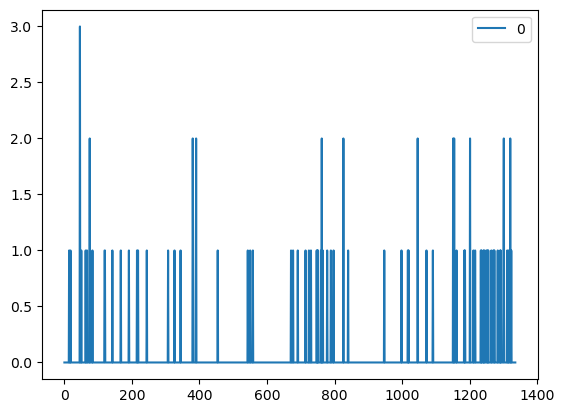

In [7]:
import pandas as pd
a = pd.read_csv("all_dur.csv")
a.plot()